In [1]:
import torch
from torch import *
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
import matplotlib
from torchvision import datasets
import torch.utils.model_zoo as model_zoo
from torch.utils.data.sampler import SubsetRandomSampler
import random as r

if torch.cuda.is_available():
  device = torch.device('cuda')
  use_cuda = True
  print('running on GPU')
else:
  device = torch.device('cpu')
  print('running on CPU')

running on GPU


# Models

In [ ]:
class Completion(nn.Module):
  def __init__(self):
    super(Completion,self).__init__()
    #----------------
    self.conv1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=5, stride=1, dilation=1, padding=2)
    self.norm1 = nn.BatchNorm2d(64)
    #---------------- CHANGE IN THE NUMBER OF OUTPUTS
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, dilation=1, padding=1)
    self.norm2 = nn.BatchNorm2d(128)

    self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, dilation=1, padding=1)
    self.norm3 = nn.BatchNorm2d(128)
    #---------------- CHANGE IN THE NUMBER OF OUTPUTS
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, dilation=1, padding=1)
    self.norm4 = nn.BatchNorm2d(256)

    self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, dilation=1, padding=1)
    self.norm5 = nn.BatchNorm2d(256)

    self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, dilation=1, padding=1)
    self.norm6 = nn.BatchNorm2d(256)

    self.dilatedconv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, dilation=2, padding=2)
    self.norm7 = nn.BatchNorm2d(256)

    self.dilatedconv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, dilation=4, padding=4)
    self.norm8 = nn.BatchNorm2d(256)

    self.dilatedconv9 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, dilation=8, padding=8)
    self.norm9 = nn.BatchNorm2d(256)

    self.dilatedconv10 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, dilation=16, padding=16)
    self.norm10 = nn.BatchNorm2d(256)

    self.conv11 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, dilation=1, padding=1)
    self.norm11 = nn.BatchNorm2d(256)

    self.conv12 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, dilation=1, padding=1)
    self.norm12 = nn.BatchNorm2d(256)
    #----------------- CHANGE IN THE NUMBER OF OUTPUTS
    self.deconv13 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, dilation=1, padding=1) #Convtranspose stride = 2 is the 1/2 stride of the paper
    self.norm13 = nn.BatchNorm2d(128)

    self.conv14 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, dilation=1, padding=1)
    self.norm14 = nn.BatchNorm2d(128)
    #----------------- CHANGE IN THE NUMBER OF OUTPUTS
    self.deconv15 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, dilation=1, padding=1)
    self.norm15 = nn.BatchNorm2d(64)

    self.conv16 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, dilation=1, padding=1)
    self.norm16 = nn.BatchNorm2d(32)

    self.output = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, dilation=1, padding=1)

    self.inside_activation = nn.ReLU(True)
    self.output_activation = nn.Sigmoid()

  def forward(self, x):
    out = self.norm1(self.inside_activation(self.conv1(x)))
    out = self.norm2(self.inside_activation(self.conv2(out)))
    out = self.norm3(self.inside_activation(self.conv3(out)))
    out = self.norm4(self.inside_activation(self.conv4(out)))
    out = self.norm5(self.inside_activation(self.conv5(out)))
    out = self.norm6(self.inside_activation(self.conv6(out)))
    out = self.norm7(self.inside_activation(self.dilatedconv7(out)))
    out = self.norm8(self.inside_activation(self.dilatedconv8(out)))
    out = self.norm9(self.inside_activation(self.dilatedconv9(out)))
    out = self.norm10(self.inside_activation(self.dilatedconv10(out)))
    out = self.norm11(self.inside_activation(self.conv11(out)))
    out = self.norm12(self.inside_activation(self.conv12(out)))
    out = self.norm13(self.inside_activation(self.deconv13(out)))
    out = self.norm14(self.inside_activation(self.conv14(out)))
    out = self.norm15(self.inside_activation(self.deconv15(out)))
    out = self.norm16(self.inside_activation(self.conv16(out)))
    return self.output_activation(self.output(out))

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    #LOCAL DISCRIMINATOR
    #input shape : [batch_size, 3, 128, 128] --> 3 x 128 x 128 

    #----------------
    self.Local_conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=2)
    self.Local_norm1 = nn.BatchNorm2d(64)
    #shape : [batch_size, 128, 64, 64] --> 64 x 64 x 64  
    self.Local_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=2)
    self.Local_norm2 = nn.BatchNorm2d(128)
    #shape : [batch_size, 256, 32, 32] --> 128 x 32 x 32

    self.Local_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=2, padding=2)
    self.Local_norm3 = nn.BatchNorm2d(256)
    #shape : [batch_size, 512, 16, 16] --> 256 x 16 x 16

    self.Local_conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, stride=2, padding=2)
    self.Local_norm4 = nn.BatchNorm2d(512)
    #shape : [batch_size, 512, 8, 8] --> 512 x 8 x 8

    self.Local_conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=5, stride=2, padding=2)
    self.Local_norm5 = nn.BatchNorm2d(512)
    #shape : [batch_size, 512, 4, 4] --> 512 x 4 x 4 = 8 192 features


    #GLOBAL DISCRIMINATOR
    #input shape : [batch_size, 3, 256, 256] --> 3 x 256 x 256 

    #----------------
    self.Global_conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=2)
    self.Global_norm1 = nn.BatchNorm2d(64)
    #shape : [batch_size, 64, 128, 128] --> 64 x 128 x 128 

    self.Global_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=2)
    self.Global_norm2 = nn.BatchNorm2d(128)
    #shape : [batch_size, 128, 64, 64] --> 128 x 64 x 64

    self.Global_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=2, padding=2)
    self.Global_norm3 = nn.BatchNorm2d(256)
    #shape : [batch_size, 256, 32, 32] --> 256 x 32 x 32

    self.Global_conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, stride=2, padding=2)
    self.Global_norm4 = nn.BatchNorm2d(512)
    #shape : [batch_size, 512, 16, 16] --> 512 x 16 x 16

    self.Global_conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=5, stride=2, padding=2)
    self.Global_norm5 = nn.BatchNorm2d(512)
    #shape : [batch_size, 512, 8, 8] --> 512 x 8 x 8

    self.Global_conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=5, stride=2, padding=2)
    self.Global_norm6 = nn.BatchNorm2d(512)
    #shape : [batch_size, 512, 4, 4] --> 512 x 4 x 4 = 8 192 features

    #----------------

    self.out_features = 8192
    self.fc = nn.Linear(self.out_features, 1024)

    #---------------- COMBINATION AND CONCATENATION

    self.final_fc = nn.Linear(2048, 1)
    self.inside_activation = nn.ReLU(True)
    self.output_activation = nn.Sigmoid()
    

  def forward(self, x):
    local_x , global_x = x #En entrée on passera un tuple avec d'abord l'image locale puis globale !
    
    Y = self.Local_norm1(self.inside_activation(self.Local_conv1(local_x)))
    Y = self.Local_norm2(self.inside_activation(self.Local_conv2(Y)))
    Y = self.Local_norm3(self.inside_activation(self.Local_conv3(Y)))
    Y = self.Local_norm4(self.inside_activation(self.Local_conv4(Y)))
    Y = self.Local_norm5(self.inside_activation(self.Local_conv5(Y)))
    Y = self.inside_activation(self.fc(Y.view(-1, self.out_features)))
   
    Z = self.Global_norm1(self.inside_activation(self.Global_conv1(global_x)))
    Z = self.Global_norm2(self.inside_activation(self.Global_conv2(Z)))
    Z = self.Global_norm3(self.inside_activation(self.Global_conv3(Z)))
    Z = self.Global_norm4(self.inside_activation(self.Global_conv4(Z)))
    Z = self.Global_norm5(self.inside_activation(self.Global_conv5(Z)))
    Z = self.Global_norm6(self.inside_activation(self.Global_conv6(Z)))
    Z = self.inside_activation(self.fc(Z.view(-1, self.out_features))) 
    
    
    out = torch.cat((Y, Z), dim=1)
    out = self.final_fc(out)
    return self.output_activation(out)


In [ ]:

lr_d = 1.
lr_c = 1.
model_c = Completion().cuda()
model_d = Discriminator().cuda()
opt_d = torch.optim.Adadelta(model_d.parameters(), lr = lr_d) 
opt_c = torch.optim.Adadelta(model_c.parameters(), lr = lr_c)
number_of_figures_saved = 0 


# Utils

In [5]:

transform = transforms.Compose([transforms.RandomResizedCrop((256,256), scale = (0.6666666666667,1.0) ,ratio=(1.0,1.0)), transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10(root="./data", transform=transform, train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root="./data", transform=transform, train=False,download=True)
dataset_with_labels = True
test_loader = torch.utils.data.DataLoader(test_set)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def size_crop() :
    """
    Defines the transformation that is applied to the images in pre-processing.
    
    """
    return transforms.RandomResizedCrop((256,256),scale = (0.6666666666667,1.0) ,ratio=(1.0,1.0))

def imshow(img):
    """
    * inputs:
          - img : [3, H, W] tensor
    """
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def mask(b_size,h = 256,w = 256, h_range_mask = (96,128), w_range_mask = (96,128),
         num_holes = 1,use_cuda = True, generate_mask = True) :
    """
    * inputs:
            - b_size : the batch size of the tensor to add the mask
            - h,w : the height and wide of the images (default = (256,256))
            - h_range_mask : int tuple of size 2 representing the min and max dimensions for the height of the
            holes. The first element must be smaller than the second which is smaller than h
            - w_range_mask : int tuple of size 2 representing the min and max dimensions for the wide of the
            holes. The first element must be smaller than the second which is smaller than w
            - num_holes : the number of desired holes in the mask
            - generate_mask : when true, will ouput a mask. If not, will only return the centers
    * returns:
            - m : A torch tensor of shape [b_size,1,256,256], representing the mask (if generate_mask is True)
            - centers : A list of int tuples of the estimated centers' coordinates of the holes (we'll need them for the localD crop)
    """
    if generate_mask :
      if use_cuda :
        m = torch.zeros((b_size,1,h,w)).cuda() #Initializing the mask
      else :
        m = torch.zeros((b_size,1,h,w))
    centers = [[] for j in range(b_size)]
    for i_holes in range(num_holes) : #Number of masks
      for i_batch in range(b_size) : #Generation of 1 mask by image
        h_mask,w_mask = r.randint(*h_range_mask),r.randint(*w_range_mask) #Acquiring hole size
        i,j = r.randint(0,h-h_mask),r.randint(0,w-w_mask) #Acquiring hole position
        centers[i_batch].append((i+h_mask//2,j+w_mask//2))
        if generate_mask :
          for x in range(h_mask) :
            for y in range(w_mask) :
              m[i_batch,0,i+x,j+y] = 1.0 #Filling the hole location with ones
    if generate_mask :
      return (m,centers)
    else :
      return(centers)

def apply_mask(x, m, pixel, use_cuda = True) :
  """
  * inputs :
      - x : a [b_size,3,H,W] shape tensor
      - m : Tensor of shape [b_size,1,H,W], representing the mask
      - pixel : The pixel value to put in the masked area int (tuple or list) in range [0,255]
  
  * outputs :
      A [b_size,4,H,W] tensor with all images patched + the mask in the the 4 elements of dim = 1
  """
  b_size,_,h,w = x.shape
  if use_cuda :
    pix = (torch.tensor(pixel).view((1, 3, 1, 1))/255.0).cuda()
  else :
    pix = torch.tensor(pixel).view((1, 3, 1, 1))/255.0
  x_patched = x - x*m + m*pix
  return torch.cat((x_patched,m),dim=1)

def visuel_mask(test_loader, n = 1, use_cuda = True) :
  """
  A visual function that will show what is a batch of images with turquoise holes
  """
  for i in range(n) :
    # get some random training images
    dataiter = iter(test_loader)
    images, _ = dataiter.next()
    m,l = mask(64,h=32,w=32,h_range_mask=(5,10),w_range_mask=(5,10), num_holes=1) #Generate an appropriate turquoise mask
    if use_cuda :
      im = apply_mask(images.cuda(),m,(64,224,208)) #Apply the mask
    else :
      im = apply_mask(images,m,(64,224,208))
    # show images with the patches
    imshow(torchvision.utils.make_grid(im[:,:3]))
    imshow(torchvision.utils.make_grid(im[:,3:]))
    return(im[:,:3],l)

def hole_cropping(x,centers,use_cuda = True) : #This function is not so generic because its particular to our problem, it returns an image half the size of the first
  """
  * inputs :
      - x : a [b_size,3,H,W] shape tensor
      - centers : a list of list of int tuples representing a (b_size,1) shape array, containing the center of the holes
  
  * outputs :
      A [b_size,3,H//2,W//2] a cropped version of the image, the crop being centered on the hole location
  """
  b_size,_,h,w = x.shape
  if use_cuda :
    t = torch.zeros((b_size,3,h//2,w//2)).cuda()
  else :
    t = torch.zeros((b_size,3,h//2,w//2))
  for i in range(b_size) :
    h1,w1 = centers[i][0] #Only take the first hole of the list, assuming there is only one hole.
    h1 = min(3*h//4,max(h//4,h1)) #If the center is too close from the edges, the holes won't be in the center
    w1 = min(3*w//4,max(w//4,w1))
    t[i] = x[i,:,h1-h//4:h1+h//4,w1-w//4:w1+w//4]
  return t

def test_and_compare(model = model_c, model_d = model_d, test_loader = test_loader, number_of_pictures = 5, h_range_mask = (96,128), w_range_mask = (96,128),
         num_holes = 1, p =0.002):
  """
  Shows images from the testloader. Original image, with mask, and the completed one.

  """
  model.eval()
  model_d.eval()
  i=0
  global number_of_figures_saved
  for data in test_loader:
    if np.random.random() < p :
      if i < number_of_pictures:
        if dataset_with_labels:
          X, Y= data
        else:
          X = data
        for x in X:
          m, centers =mask(b_size=1, h_range_mask = h_range_mask, w_range_mask = w_range_mask,
         num_holes = num_holes)
          centers_true =mask(b_size=1, h_range_mask = h_range_mask, w_range_mask = w_range_mask,
         num_holes = num_holes, generate_mask = False)
          plt.figure(figsize = [15, 5])
          #imshow((x.cuda().view(3, 256, 256)))
          image1 = (x.cuda().view(3, 256, 256))
          ax1 = plt.subplot(1, 3, 1)
          npimg1 = (image1.cpu().numpy())
          plt.imshow(np.transpose(npimg1, (1, 2, 0)))
          #imshow((x.cuda() - x.cuda()* m).view(3, 256, 256))
          image2 = (x.cuda() - x.cuda()* m).view(3, 256, 256)
          ax2 = plt.subplot(1, 3, 2)
          npimg2 = (image2.cpu().numpy())
          plt.imshow(np.transpose(npimg2, (1, 2, 0)))
          x = x.view(1, 3, 256, 256) #to apply the mask : x is equivalent to a batch of size 1
          if use_cuda:
            im = apply_mask(x.cuda(), m, pixel).view(4, 256, 256)
          else:
            im = apply_mask(x, m, pixel).view(4, 256, 256)
          model_c_input = im.view(1, 4, 256, 256)
          model_c_output = model(model_c_input)
          recombined_output = x.cuda() - x.cuda() * m + model_c_output * m
          #imshow(recombined_output.detach().view(3, 256, 256))
          image3 = recombined_output.detach().view(3, 256, 256)
          ax3 = plt.subplot(1, 3, 3)
          npimg3 = (image3.cpu().numpy())
          input_true_ld = hole_cropping(x.cuda().detach(),centers_true,use_cuda = use_cuda)
          output_true_d = model_d((input_true_ld,x.cuda().detach()))
          prob_t = output_true_d.item()
          input_ld = hole_cropping(model_c_output,centers,use_cuda = use_cuda)
          output_d = model_d((input_ld,model_c_output))
          prob = output_d.item()
          plt.title("P(True) = True : {} - P(False) = True : {}".format(prob_t,prob), loc = 'center')
          plt.imshow(np.transpose(npimg3, (1, 2, 0)))
          #plt.savefig('saves/figures/fig{}.png'.format(number_of_figures_saved+1)) #Choose your directory
          number_of_figures_saved += 1
      else: 
        break
      i+=1
  
def save_checkpoint(state, filename):
  """
  Save the state checkpoint in a directory
  """
  print('=> Saving {}'.format(filename))
  torch.save(state, filename)

def load_checkpoint(model, optimizer, filename):
  """
  Loads the model and optimizer contained in a file, into the model and optimizer passed in the function.
  *inputs:
  - model : a model initialized with the corresponding class
  - optimizer : an adadelta optimizer initialized with the model parameters
  - filename : the filename of the model to be loaded
  """
  print('=> Loading {} into the model'.format(filename))
  checkpoint = torch.load(filename)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  print("Model and optimizer loaded")


# Dataset

In [7]:
"""
train_set = torchvision.datasets.ImageFolder(root = "data/train_set", transform = transform) #200K images -1 allant de 1 à 199999
test_set = torchvision.datasets.ImageFolder(root = "data/test_set", transform = transform) #2600 images #A modifier pour prendre les images de 200000 à 202599
dataset_with_labels = True
test_loader = torch.utils.data.DataLoader(test_set)
number_of_figures_saved = 142

fun_set = torchvision.datasets.ImageFolder(root = "data/fun_set", transform = transform)
fun_loader = torch.utils.data.DataLoader(fun_set)
"""

'\ntrain_set = torchvision.datasets.ImageFolder(root = "data/train_set", transform = transform) #200K images -1 allant de 1 à 199999\ntest_set = torchvision.datasets.ImageFolder(root = "data/test_set", transform = transform) #2600 images #A modifier pour prendre les images de 200000 à 202599\ndataset_with_labels = True\ntest_loader = torch.utils.data.DataLoader(test_set)\nnumber_of_figures_saved = 142\n\nfun_set = torchvision.datasets.ImageFolder(root = "data/fun_set", transform = transform)\nfun_loader = torch.utils.data.DataLoader(fun_set)\n'

In [ ]:
def pixel_moyen(dataset = train_set) :
  pix = torch.zeros(3)
  n = len(dataset)
  for i in tqdm(range(n)) :
    data = dataset[i]
    if dataset_with_labels :
      data = data[0]
    r = data[0].mean()
    g = data[1].mean()
    b = data[2].mean()
    t = torch.tensor([r,g,b])
    pix += t
  pix = (255.0/n) * pix
  return(tuple(pix))

#pixel_moyen()

# Hyperparameters

In [9]:
'''
lr_d = 1.
lr_c = 1.
model_c = Completion().cuda()
model_d = Discriminator().cuda()
opt_d = torch.optim.Adadelta(model_d.parameters(), lr = lr_d) 
opt_c = torch.optim.Adadelta(model_c.parameters(), lr = lr_c) 
'''

'\nlr_d = 1.\nlr_c = 1.\nmodel_c = Completion().cuda()\nmodel_d = Discriminator().cuda()\nopt_d = torch.optim.Adadelta(model_d.parameters(), lr = lr_d) \nopt_c = torch.optim.Adadelta(model_c.parameters(), lr = lr_c) \n'

# Trainers

In [ ]:
pixel = (130,107,95) #This is the mean value of all pixels in the training data_set !

In [ ]:
def C_loss(input, output, mask) : #The loss for the completion network is calculed only in the completed region !
  return F.mse_loss(output*mask, input*mask)


def train_C(model_c, optimizer = opt_c, train_set = train_set, learning_rate = 1.0, train_acc_period = 100,
            n_epoch = 5, save_period = 10000, batch_size = 8, num_samples = 1000, use_cuda = True) : #On pourra éventuellement rajouter un test sur une image à intervalle réguliers
  
  model_c.train()
  i = 0
  for epoch in tqdm(range(n_epoch)) :
    train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, num_workers=6, sampler= torch.utils.data.RandomSampler(train_set, replacement=True, num_samples=num_samples), pin_memory=True, drop_last = True) #On en parlera de ces paramètres là !
    running_loss = 0.0
    for data in tqdm(train_loader) : 
      if dataset_with_labels:
        x, y = data
      else:
        x = data
      
      if use_cuda :
        x = x.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      m, _ = mask(batch_size, use_cuda = use_cuda)
      inputs = apply_mask(x,m,pixel, use_cuda = use_cuda)
      outputs = model_c(inputs)
          
      loss = C_loss(x,outputs,m)
      loss.backward()
      optimizer.step()

      # printing some statistics
      running_loss = 0.33*loss.item()/batch_size + 0.66*running_loss
      if i % train_acc_period == train_acc_period-1:
        print('[%d, %5d] loss: %f' %(epoch + 1, i + 1, running_loss))
        running_loss = 0.0
      i += 1
      del x #Je sais pas si c'est utile ! mon but c'est de désalouer la mémoire pour être sûr de pas dépasser la capacité de CUDA
    if (epoch%save_period == save_period-1) or (epoch == n_epoch - 1):
        filename = "model_c_save/model_c_checkpoint_c_training_epoch{:d}.pth.tar".format(epoch+1)
        save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model_c.state_dict(),
                'optimizer' : optimizer.state_dict(),
            }, filename = filename)
  print ("Finished Training C")


def train_D(model_d, model_c, optimizer = opt_d,  train_set = train_set, learning_rate = 1.0, train_acc_period = 100,
            n_epoch = 5, save_period = 10000, batch_size = 8, num_samples = 1000, use_cuda = True) :

  model_c.eval() 
  model_d.train()
  i = 0
  criterion = nn.BCELoss()
  for epoch in tqdm(range(n_epoch)) :
    train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, num_workers=6, sampler= torch.utils.data.RandomSampler(train_set, replacement=True, num_samples=num_samples), pin_memory=True, drop_last = True) #On en parlera de ces paramètres là !
    running_loss = 0.0
    for data in tqdm(train_loader) : 
      if dataset_with_labels:
          x, _ = data
      else:
          x = data

      if use_cuda :
        x = x.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # Feeding the network with completed images

      mask_c, centers_c = mask(batch_size, use_cuda = use_cuda)
      input_c = apply_mask(x, mask_c ,pixel, use_cuda = use_cuda)
      output_c = model_c(input_c)
      false = torch.zeros((batch_size,1)) #The context discriminator should label all images as fake
      if use_cuda :
        false = false.cuda()
      input_gd_fake = output_c.detach() #We don't need the gradients for this batch, as the Generator is not trained here
      input_ld_fake = hole_cropping(input_gd_fake,centers_c,use_cuda = use_cuda)
      output_fake = model_d((input_ld_fake,input_gd_fake))
      loss_fake = criterion(output_fake, false) #Loss if labelled as true

      # Feeding the network with real images
      centers_d = mask(batch_size, use_cuda = use_cuda, generate_mask = False) #Only generate the hole centers, but not the tensors as it is expensive !
      input_gd_real = x
      input_ld_real = hole_cropping(input_gd_real,centers_d,use_cuda = use_cuda) 
      output_real = model_d((input_ld_real,input_gd_real))
      real = torch.ones((batch_size,1)) #Tensor of ones indicating that images are labelled as true (1)
      if use_cuda :
        real = real.cuda()
      loss_real = criterion(output_real,real) #Loss if labelled as false

      # Recombining the losses
      loss = (loss_real + loss_fake)/2.0 #The coefficient of each kind of losses could be a way to personalize the net !
      loss.backward()
      optimizer.step()

      # printing some statistics
      running_loss = 0.33*loss.item()/batch_size + 0.66*running_loss
      if i % train_acc_period == train_acc_period-1:
        print('[%d, %5d] loss: %f' %(epoch + 1, i + 1, running_loss))
        running_loss = 0.0
      i += 1
      del x #Je sais pas si c'est utile ! mon but c'est de désalouer la mémoire pour être sûr de pas dépasser la capacité de CUDA
    if (epoch%save_period == save_period-1) or (epoch == n_epoch - 1):
      filename = "model_d_save/model_d_checkpoint_d_training_epoch{:d}.pth.tar".format(epoch+1)
      save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model_d.state_dict(),
            'optimizer' : optimizer.state_dict(),
            }, filename = filename)
  print ("Finished Training D")

def train_C_and_D(model_c, model_d, alpha, optimizer_c = opt_c, optimizer_d = opt_d, train_set = train_set, lr_c = 1.0, lr_d = 1.0 ,train_acc_period = 100,
            n_epoch = 5, save_period = 10000, batch_size = 8, num_samples = 1000, use_cuda = True) :

  running_loss_c = 0
  running_loss_d = 0
  model_c.train() 
  model_d.train()
  i = 0
  criterion = nn.BCELoss()
  for epoch in tqdm(range(n_epoch)) :
    train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, num_workers=6, sampler= torch.utils.data.RandomSampler(train_set, replacement=True, num_samples=num_samples), pin_memory=True, drop_last = True)
    for data in tqdm(train_loader) : #Normalement on prendra un dataset unsupervised donc sans labels, mais on laisse le choix
      if dataset_with_labels:
        x, _ = data
      else:
        x = data

      if use_cuda :
        x = x.cuda()

      # zero the parameter gradients

      opt_c.zero_grad()
      opt_d.zero_grad()

      # Training the completion network

      mask_c, centers_c = mask(batch_size, use_cuda = use_cuda)
      input_c = apply_mask(x,mask_c,pixel, use_cuda = use_cuda)
      output_c = model_c(input_c)
      loss_c_1 = C_loss(x,output_c,mask_c)

      # Feeding the discrimination network with completed images

      false = torch.zeros((batch_size,1)) #The context discriminator should label all images as fake
      if use_cuda :
        false = false.cuda()
      input_gd_fake = output_c.detach() #We detach here so that the gradients are not used, only doing a backward pass for D
      input_ld_fake = hole_cropping(input_gd_fake,centers_c,use_cuda = use_cuda)
      output_fake = model_d((input_ld_fake,input_gd_fake))
      loss_fake = criterion(output_fake, false) #Loss if labelled as true

      # Feeding the discrimination network with real images

      centers_d = mask(batch_size, use_cuda = use_cuda, generate_mask = False)
      input_gd_real = x
      input_ld_real = hole_cropping(input_gd_real,centers_d,use_cuda = use_cuda) #I used the same mask than in the false feeding, i think it's okay and faster.
      output_real = model_d((input_ld_real,input_gd_real))
      real = torch.ones((batch_size,1)) #Tensor of ones indicating that images are labelled as true (1)
      if use_cuda :
        real = real.cuda()
      loss_real = criterion(output_real,real) #Loss if labelled as false

      # Updating the Discriminator model

      loss_d = alpha * (loss_real + loss_fake) #The coefficient of each kind of losses could be a way to personalize the net !
      loss_d.backward()
      opt_d.step()
      
      # Computing the second loss for the completion network 

      input_gd_fake = output_c #Not detaching now because we will use the gradients
      input_ld_fake = hole_cropping(input_gd_fake,centers_c,use_cuda = use_cuda)
      output_fake = model_d((input_ld_fake,input_gd_fake))
      loss_c_2 = criterion(output_fake,real) #Indeed, the completion network must lure the discriminatoir, hence this loss !

      # Updating the Completion model

      loss_c = (loss_c_1 + alpha * loss_c_2)
      loss_c.backward()
      opt_c.step()

      # printing some statistics

      running_loss_c = 0.33*loss_c.item()/batch_size + 0.66*running_loss_c
      running_loss_d = 0.33*loss_d.item()/batch_size + 0.66*running_loss_d
      if i % train_acc_period == train_acc_period-1:
        print('[%d, %5d] loss for the completion network : %f' %(epoch + 1, i + 1, running_loss_c))
        print('[%d, %5d] loss for the discrimination network : %f' %(epoch + 1, i + 1, running_loss_d))
        running_loss_c, running_loss_d = 0, 0
      i += 1
      del x #Je sais pas si c'est utile ! mon but c'est de désalouer la mémoire pour être sûr de pas dépasser la capacité de CUDA
    if (epoch%save_period == save_period-1) or (epoch == n_epoch - 1):
        filename1 = "model_c_save/model_c_checkpoint_c_and_d_training_epoch{:d}.pth.tar".format(epoch+1)
        save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model_c.state_dict(),
                'optimizer' : opt_c.state_dict(),
            }, filename = filename1)
        filename2 = "model_d_save/model_d_checkpoint_c_and_d_training_epoch{:d}.pth.tar".format(epoch+1)
        save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model_d.state_dict(),
                'optimizer' : opt_d.state_dict(),
            }, filename = filename2)
  print ("Finished Training C&D simultaneously")

# Allocation, training and testing

In [ ]:
alpha = 4e-4

In [ ]:
n = 8
#load_checkpoint(model_c,opt_c,"model_c_save/model_c_checkpoint_c_and_d_training_epoch{}.pth.tar".format(n))
#load_checkpoint(model_d,opt_d,"model_d_save/model_d_checkpoint_c_and_d_training_epoch{}.pth.tar".format(n))

In [14]:
train_C(model_c, batch_size = 16 , train_acc_period = 50, n_epoch = 10, num_samples = 8000, save_period = 5)

KeyboardInterrupt: ignored

In [15]:
print('Entrainement seulement du Discriminateur')
train_D(model_d, model_c, train_acc_period = 50, batch_size = 16, num_samples= 8000, save_period = 2, n_epoch = 5) 

Entrainement seulement du Discriminateur


KeyboardInterrupt: ignored

In [16]:
print('Entrainement des deux à la fois')
train_C_and_D(model_c, model_d, alpha, n_epoch=10, train_acc_period = 50, batch_size = 16, num_samples = 8000, save_period = 5)

Entrainement des deux à la fois


KeyboardInterrupt: ignored

In [17]:
n = 1
"""
load_checkpoint(model_c,opt_c,"model_c_save/model_c_checkpoint_eot9.pth.tar")
load_checkpoint(model_d,opt_d,"model_d_save/model_d_checkpoint_eot9.pth.tar")
"""

'\nload_checkpoint(model_c,opt_c,"model_c_save/model_c_checkpoint_eot9.pth.tar")\nload_checkpoint(model_d,opt_d,"model_d_save/model_d_checkpoint_eot9.pth.tar")\n'

NameError: ignored

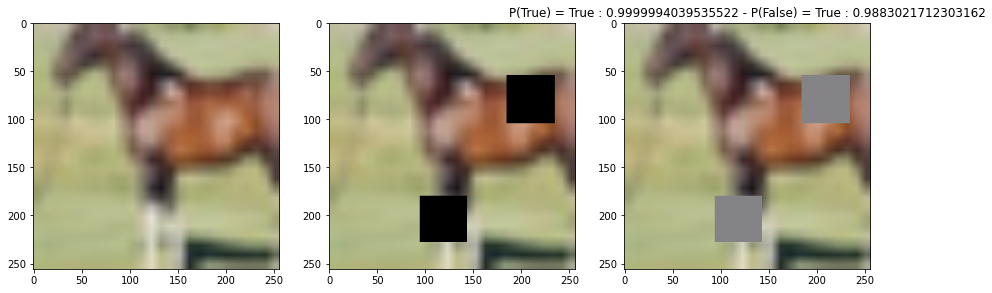

In [18]:
test_and_compare(model_c, model_d, test_loader, number_of_pictures = 5, h_range_mask = (48,50), w_range_mask = (48,50),
         num_holes = 2, p = 0.01)

In [ ]:
'''
filename1 = "model_c_save/model_c_checkpoint_eot{:d}.pth.tar".format(9)
save_checkpoint({
        'epoch': 0,
        'state_dict': model_c.state_dict(),
        'optimizer' : opt_c.state_dict(),
    }, filename = filename1)



filename2 = "model_d_save/model_d_checkpoint_eot{:d}.pth.tar".format(9)
save_checkpoint({
        'epoch': 0,
        'state_dict': model_d.state_dict(),
        'optimizer' : opt_d.state_dict(),
    }, filename = filename2)
